# Phase 3


## Libraries

In [1]:
!pip install pytorch-tabnet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.5/44.5 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.0 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 30.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.1 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 81.5 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.8.93
    Uninstalling nvidia-nvjitlink-cu12-12.8.93:
      Successfully uninstalled nvidia-nvjitlink-cu12-12.8.93
  Attempting uninstall: nvidia-curand-cu12
    Found existing in

In [2]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

import time
import optuna
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_squared_log_error
from sklearn.model_selection import train_test_split
import time
from scipy.special import inv_boxcox

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchinfo import summary

from tqdm import tqdm
from pytorch_tabnet.tab_model import TabNetRegressor


## Data Preprocessing

### Feature Engineering
- From previous EDA notebook, we already knew that `feature_12` is time-related features, therefore, we would extract `day`, `month`, `year`, ... and create periodic features with sin and cos of month and day. 
- Then, we gotta drop the `id` and `feature_12` since these are no longer useful.

In [ ]:
train = pd.read_csv('/kaggle/input/introml-clc-hk2-2425/train.csv')
test = pd.read_csv('/kaggle/input/introml-clc-hk2-2425/test.csv')

if 'target' in test.columns:
    test['feature_16'] = test.pop('target')

train['feature_12'] = pd.to_datetime(train['feature_12'])
train['year'] = (train['feature_12']).dt.year
train['month'] = (train['feature_12']).dt.month
train['day'] = (train['feature_12']).dt.day
train['dow'] = (train['feature_12']).dt.dayofweek
train['week'] = train['feature_12'].dt.isocalendar().week

train['month_sin'] = np.sin(2 * np.pi * (train['month'] - 1) / 12)
train['month_cos'] = np.cos(2 * np.pi * (train['month'] - 1) / 12)
train['day_sin'] = np.sin(2 * np.pi * (train['day'] - 1) / 31)
train['day_cos'] = np.cos(2 * np.pi * (train['day'] - 1) / 31)

test['feature_12'] = pd.to_datetime(test['feature_12'])
test['year'] = (test['feature_12']).dt.year
test['month'] = (test['feature_12']).dt.month
test['day'] = (test['feature_12']).dt.day
test['dow'] = (test['feature_12']).dt.dayofweek
test['week'] = (test['feature_12']).dt.isocalendar().week

test['month_sin'] = np.sin(2 * np.pi * (test['month'] - 1) / 12)
test['month_cos'] = np.cos(2 * np.pi * (test['month'] - 1) / 12)
test['day_sin'] = np.sin(2 * np.pi * (test['day'] - 1) / 31)
test['day_cos'] = np.cos(2 * np.pi * (test['day'] - 1) / 31)

train = train.drop(columns=['feature_12'])
test = test.drop(columns=['feature_12'])
train = train.drop(columns=['id'])
test = test.drop(columns=['id'])



### Handle Missing Values

In [4]:
# Check for missing values
missing_values = train.isnull().sum()
missing_values = missing_values[missing_values > 0]
missing_values.sort_values(inplace=True)
missing_ratio = missing_values / len(train) * 100
missing_values = pd.concat([missing_values, missing_ratio], axis=1, keys=['Total', 'Ratio'])
missing_values

,Total,Ratio
feature_11,1,0.000083
feature_9,6,0.000500
feature_1,18529,1.544083
Age,18705,1.558750
feature_0,44949,3.745750
feature_5,74076,6.173000
feature_13,77824,6.485333
feature_2,109672,9.139333
feature_10,137882,11.490167
feature_4,358075,29.839583


Since from EDA notebook, we already knew that `nan` values has relationship with `target`, therefore we will try imputing `median` to fill missing values in numerical features and `Unknown` for categorical features.

In [5]:
# Use simple imputer to fill missing values
from sklearn.impute import SimpleImputer

numerical_missing_vals = ['Age', 'feature_0', 'feature_2', 'feature_5', 'feature_8', 'feature_9', 'feature_10', 'feature_11']
categorical_missing_vals = ['feature_1', 'feature_4', 'feature_13']

numerical_imputer = SimpleImputer(strategy='median')


train[numerical_missing_vals] = numerical_imputer.fit_transform(train[numerical_missing_vals])
train[categorical_missing_vals] = train[categorical_missing_vals].fillna('Unknown')

test[numerical_missing_vals] = numerical_imputer.transform(test[numerical_missing_vals])
test[categorical_missing_vals] = test[categorical_missing_vals].fillna('Unknown')



### Encoding
- Since from the EDA, we already knew that which one should get one-hot encoded, label encoded and ordinal encoded.

In [6]:
from sklearn.preprocessing import LabelEncoder, StandardScaler, RobustScaler, OneHotEncoder, OrdinalEncoder
features_for_one_hot = ['Gender', 'feature_1', 'feature_4', 'feature_6', 'feature_16']
features_for_label = ['feature_14']
features_for_ordinal = ['feature_3', 'feature_7', 'feature_13', 'feature_15']

ordinal_features = {
    'feature_3':['High School', "Bachelor's", "Master's", 'PhD'],
    'feature_7': ['Basic', 'Comprehensive', 'Premium'],
    'feature_13': ['Poor', 'Average', 'Good'] ,
    'feature_15': ['Rarely', 'Monthly', 'Weekly', 'Daily'],
}

train[features_for_one_hot] = train[features_for_one_hot].astype(str)
test[features_for_one_hot] = test[features_for_one_hot].astype(str)

ohe = OneHotEncoder(sparse_output=True, handle_unknown='ignore')
ohe.fit(train[features_for_one_hot])

ohe_array = ohe.transform(train[features_for_one_hot]).toarray()
ohe_df = pd.DataFrame(ohe_array, columns=ohe.get_feature_names_out(features_for_one_hot), index=train.index)
train = pd.concat([train.drop(columns=features_for_one_hot), ohe_df], axis=1)

test_ohe_array = ohe.transform(test[features_for_one_hot]).toarray()
test_ohe_df = pd.DataFrame(test_ohe_array, columns=ohe.get_feature_names_out(features_for_one_hot), index=test.index)
test = pd.concat([test.drop(columns=features_for_one_hot), test_ohe_df], axis=1)

for feature in features_for_label:
    le = LabelEncoder()
    train[feature] = le.fit_transform(train[feature])
    test[feature] = le.transform(test[feature])
    
for feature, order in ordinal_features.items():
    oe = OrdinalEncoder(categories=[order], handle_unknown='use_encoded_value', unknown_value=-1)
    train[feature] = oe.fit_transform(train[[feature]]).flatten()
    test[feature] = oe.transform(test[[feature]]).flatten()


- For skewed feature like `feature_0`, we also used log-transformation (although we tried other methods like `box-cox` and `sqrt-transformation` but the result is not quite good therefore, we still sticked to `log-transformation`).

In [7]:
features_for_robust = ['feature_0']
for feature in features_for_robust:
    train[feature] = np.log1p(train[feature])
    test[feature] = np.log1p(test[feature])


In [8]:
X = train.drop(columns=['target'])
y = train['target']

### Distribution of Target

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


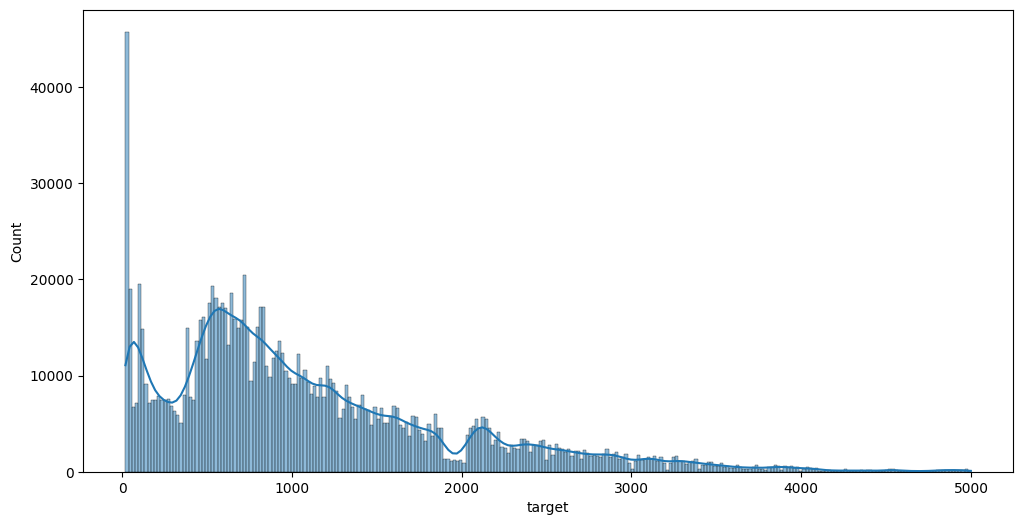

In [9]:
# Plot the distribution of the target variable
plt.figure(figsize=(12, 6))
sns.histplot(y, kde=True)
plt.show()

Since we already knew that the metric was evaluated is `RMSLE`, therefore using `log-transformation` on target is the best:
- Alignment with the Metric: RMSLE measures errors in the log space (log(1+y)). By taking the mean in the log space and exponentiating back, you’re finding the value that minimizes the squared logarithmic differences, which is exactly what RMSLE evaluates.
- Relative Errors: RMSLE cares about relative errors (e.g., a 10% error is the same whether the true value is 100 or 10,000). The log transformation converts relative errors into additive differences, and the mean in this space corresponds to the geometric mean in the original space, which aligns with RMSLE’s focus on relative errors.

In [10]:
y_log = np.log1p(y)
y_log

0          7.962067
1          7.302496
2          6.342121
3          6.641182
4          7.612337
             ...   
1199995    7.173192
1199996    6.711740
1199997    5.918894
1199998    6.391917
1199999    7.816417
Name: target, Length: 1200000, dtype: float64

### Feature Selection

Use RandomForest algorithm for selecting 15 most important features, which can help:
- Speed up training.
- Improve generalization (reduce overfitting).
- Make the model easier to interpret.

In [11]:
X_temp, X_fs, y_train, y_fs = train_test_split(X, y , test_size = 0.05)

In [12]:
from sklearn.ensemble import RandomForestRegressor
import pandas as pd

model = RandomForestRegressor(random_state = 1)
model.fit(X_fs, y_fs)

# Lấy importance
importances = model.feature_importances_
feature_importance = pd.Series(importances, index=X_fs.columns)
top_features = feature_importance.nlargest(15).index
print("Selected top features: ",top_features)

X = train[top_features]
test = test[top_features]

Selected top features:  Index(['feature_5', 'feature_0', 'feature_10', 'Age', 'feature_9', 'day_sin',
       'week', 'feature_11', 'year', 'day', 'day_cos', 'dow', 'feature_13',
       'feature_2', 'feature_15'],
      dtype='object')


### Data Retyping

In [13]:
X = X.astype(np.float32)

### Train Test Validation Split

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y_log, test_size=0.2, random_state=42)
X_temp, X_optuna, y_temp, y_optuna = train_test_split(X_train, y_train, test_size = 0.05, random_state = 42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.05, random_state=42)
X_optuna, X_val_optuna, y_optuna, y_val_optuna = train_test_split(X_optuna, y_optuna, test_size = 0.2, random_state = 42)


## Modeling

### Helper Functions

In [15]:

models_performance = {
    'mae' : [],
    'mse' : [],
    'r2' : [],
    'rmsle' : [],
    'train_time' : [],
    'model' : []
}

def root_mean_squared_log_error(y_true, y_pred):
    return np.sqrt(mean_squared_log_error(y_true, y_pred))

def make_prediction_loader(model, test_loader, device):
    model.eval()
    y_true_list = []
    y_pred_list = []

    with torch.inference_mode():
        for X_test, y_test in test_loader:
            X_test, y_test = X_test.to(device), y_test.to(device)

            y_pred = model(X_test)

            y_test = y_test.unsqueeze(1) if y_test.dim() == 1 else y_test
            y_pred = y_pred.unsqueeze(1) if y_pred.dim() == 1 else y_pred

            y_true_list.append(y_test.detach().cpu().numpy())
            y_pred_list.append(y_pred.detach().cpu().numpy())

    y_true = np.concatenate(y_true_list, axis=0)
    y_pred = np.concatenate(y_pred_list, axis=0)

    return y_true, y_pred

### Setup Device Agnostic Code

+ GPU decrease the training time dramastically.
+ Change device into GPU (cuda) if a GPU is availble. 

In [16]:
!nvidia-smi 2>&1 | grep -i "cuda"

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
DEVICE

| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |


'cuda'

### Dataset

+ PyTorch provides two data primitives: `torch.utils.data.DataLoader` and `torch.utils.data.Dataset` that allow you to use pre-loaded datasets as well as your own data. Dataset stores the samples and their corresponding labels, and DataLoader wraps an iterable around the Dataset to enable easy access to the samples.

Reference:
+ https://pytorch.org/tutorials/beginner/basics/data_tutorial.html 4/4/2025

The custom dataset that take DataFrame and Labels, to organize and feed into DataLoader

In [17]:
class MyDataset(Dataset):
    def __init__(self, dataframe : pd.DataFrame, labels : pd.Series):
        self.data_frame = dataframe
        self.labels = labels

    def __len__(self) :
        return len(self.labels)

    def __getitem__(self, idx):
        
        feature = self.data_frame.iloc[idx].values
        label = self.labels.iloc[idx]

        feature_tensor = torch.tensor(feature, dtype=torch.float32)
        label_tensor = torch.tensor(label, dtype=torch.float32)

        return feature_tensor, label_tensor

train_dataset = MyDataset(X_train, y_train)
test_dataset = MyDataset(X_test, y_test)
val_dataset = MyDataset(X_val, y_val)
                       
tune_dataset = MyDataset(X_optuna, y_optuna)
val_optuna_dataset = MyDataset(X_val_optuna, y_val_optuna)

### DataLoader

Load data to feed into the model

In [18]:
BATCH_SIZE = 128
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True, num_workers = 4)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True,num_workers = 4)
tune_loader = DataLoader(tune_dataset, batch_size=BATCH_SIZE, shuffle=True,pin_memory=True,num_workers = 4)
val_optuna= DataLoader(val_optuna_dataset, batch_size=BATCH_SIZE, shuffle=True,pin_memory=True,num_workers = 4)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True,pin_memory=True,num_workers = 4)


In [19]:
X_sample, y_sample = next(iter(train_loader))

INPUT_SIZE = X_sample.shape[1]

### Train Loop

Training process consists of 3 parts :
+ Train step:
  + This is the main training process for 1 epoch
  + For every batch in train DataLoader :
    + Move data into device (cpu or gpu)
    + Perform forward propagation
    + Calculate loss
    + Perform backward propagation
  + After an ammount of batches, perform validate on the validation DataLoader
  + Update scheduler if necessary
  + Return average MAE, MSE and R2 of the validation data
+ Validation step and Test step:
    + Perform calculating the metrics : MAE, MSE, R2
+ Train model :
     + Loop through every step and perform training for a certain ammount of epochs

Rererence:
+ https://youtu.be/V_xro1bcAuA?si=qd6FYTIyGrIxIvAL 4/4/2025
    

In [20]:
def train_step(model, train_loader, loss_fn, optimizer, device, scheduler=None, log_period=None, val_loader=None):

    model.to(device)
    model.train()
    train_data = tqdm(train_loader, leave=True, desc="Training")

    avg_mae = 0
    avg_mse = 0
    avg_r2 = 0
    
    for batch_idx, (X_train, y_train) in enumerate(train_data, start=1):
        
        X_train, y_train = X_train.to(device), y_train.to(device)

        if log_period is not None:
          if batch_idx % log_period == 0:
              model.eval()
              with torch.no_grad():
                  if val_loader:
                      mae, mse, r2 = validation_step(model, val_loader, device)
                  else:
                      mae, mse, r2 = validation_step(model, train_loader, device)

                  train_data.set_postfix({"Loss": loss.item(), "MAE": mae, "MSE": mse, "R2": r2})
                  avg_mae += mae
                  avg_mse += mse
                  avg_r2 += r2
              model.train()

        y_pred = model(X_train)
        y_pred = y_pred.squeeze()
        loss = loss_fn(y_pred, y_train)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if scheduler:
        scheduler.step(loss.item())
        
    if log_period is not None:
        num_logs = len(train_loader) // log_period
        avg_mae /= num_logs
        avg_mse /= num_logs
        avg_r2 /= num_logs

    return avg_mae, avg_mse, avg_r2

def validation_step(model, val_loader, device):
    model.to(device)
    model.eval()

    y_true_list = []
    y_pred_list = []

    with torch.inference_mode():
        for X_val, y_val in val_loader:
            X_val, y_val = X_val.to(device), y_val.to(device)
            y_pred = model(X_val).squeeze()

            if torch.isnan(y_pred).any():
                continue

            y_true_list.extend(y_val.cpu().detach().numpy())
            y_pred_list.extend(y_pred.cpu().detach().numpy())

    if not y_true_list or not y_pred_list:
        print("NaN values detected during prediction. Validation step skipped.")
        return math.inf, math.inf, 0

    y_true_array = np.array(y_true_list)
    y_pred_array = np.array(y_pred_list)

    mae = mean_absolute_error(y_true_array, y_pred_array)
    mse = mean_squared_error(y_true_array, y_pred_array)
    r2 = r2_score(y_true_array, y_pred_array)

    return mae, mse, r2

def test_step(model, test_loader, device):
    model.to(device)
    model.eval()

    y_true_list, y_pred_list = [], []
    test_data = tqdm(test_loader, leave=True, desc="Testing")

    with torch.inference_mode():
        for X_test, y_test in test_data:
            X_test, y_test = X_test.to(device), y_test.to(device)

            y_pred = model(X_test)

            y_test = y_test.unsqueeze(1) if len(y_test.shape) == 1 else y_test
            y_pred = y_pred.unsqueeze(1) if len(y_pred.shape) == 1 else y_pred

            if torch.isnan(y_pred).any():
                continue

            y_true_list.append(y_test.cpu().numpy())
            y_pred_list.append(y_pred.cpu().numpy())

    if not y_true_list or not y_pred_list:
        print("Nan values detected while predicting, consider skipping this test result")
        return math.inf, math.inf, 0
        
    y_true = np.concatenate(y_true_list, axis=0)
    y_pred = np.concatenate(y_pred_list, axis=0)

    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    return mae, mse, r2


def train_model(model, train_loader, test_loader, loss_fn, optimizer, device, scheduler = None, epochs=3, val_loader = None, log_period=None):

    metrics = {
    'train_mae': [],
    'train_mse': [],
    'train_r2': [],
    'test_mae': [],
    'test_mse': [],
    'test_r2': [],
    }
    
    for epoch in range(epochs):
        print(f"\nEpoch {epoch+1}/{epochs}:")
        train_mae, train_mse, train_r2 = train_step(model, train_loader, loss_fn, optimizer, device, scheduler, log_period=log_period, val_loader=val_loader)
        test_mae, test_mse, test_r2 = test_step(model, test_loader, device)
        print(f"MAE : {test_mae:.5f} | MSE : {test_mse:.5f} | R2 : {test_r2:.5f}")

        metrics['train_mae'].append(train_mae)
        metrics['train_mse'].append(train_mse)
        metrics['train_r2'].append(train_r2)
        metrics['test_mae'].append(test_mae)
        metrics['test_mse'].append(test_mse)
        metrics['test_r2'].append(test_r2)
    return metrics

### Linear Model

First model is a simple feed forward Neural Network, it consists of :
+ Input layer with input dim equal to the number of the input features.
+ Fully connected layers, they are connected linearly, might help detect linear relationship.
+ No activation function.
+ Output layer consists of 1 single neuron, designed for regression problem.

In [21]:
class LinearModel(nn.Module):
  def __init__(self, input_size, hidden_size, n_layers = 5):
    super().__init__()

    layers = [nn.Linear(in_features=input_size, out_features=hidden_size)]
    for i in range(n_layers):
      layers.append(nn.Linear(in_features=hidden_size, out_features=hidden_size))
    layers.append(nn.Linear(in_features=hidden_size, out_features=1))

    self.fc_layer = nn.Sequential(*layers)
  def forward(self, X):
    return self.fc_layer(X)

#### Hyperparameters Tunning

Hyperparameters tunning for the LinearModel, including:
+ `lr` : Learning rate, float value from 0.00001 to 0.01
+ `hidden_size` : Number of neurons in each layer of the model, value range from 16, 32, 64 to 128
+ `n_layers` : Number of hidden layers, the more layer the deeper model but more risk of overfitting, vanishing gradients, slower training.
+ `weight_decay` : L2 regularization strength; discourages large weights. Float value from 0.000001 to 0.01
+ `optimizer` : Trial between SGD, Adam, AdamW, are popular optimizer in deep learning
+ `loss function` : Between MAE or MSE

There are 15 trials in total, each trial will run through the hypertune dataset for 5 epochs to find the best params dict

In [22]:
# def objective(trial):
#     lr = trial.suggest_float("lr", 1e-5, 1e-2, log=True)
#     hidden_size = trial.suggest_categorical("hidden_size", [16, 32, 64, 128])
#     n_layers = trial.suggest_int("n_layers", 1, 10)
#     weight_decay = trial.suggest_float("weight_decay", 1e-6, 1e-2, log=True)

#     optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "AdamW", "SGD"])
#     loss_name = trial.suggest_categorical("loss function", ['MSE', 'MAE'])

#     model = LinearModel(input_size=INPUT_SIZE, hidden_size=hidden_size, n_layers=n_layers).to(DEVICE)

#     if loss_name == 'MSE':
#         loss_fn = nn.MSELoss()
#     else:
#         loss_fn = nn.L1Loss()

#     if optimizer_name == "Adam":
#         optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
#     elif optimizer_name == 'AdamW':
#         optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
#     else:
#         optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=weight_decay)

#     scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)

#     metrics = train_model(
#         model=model,
#         train_loader=tune_loader,
#         test_loader=val_optuna,
#         loss_fn=loss_fn,
#         optimizer=optimizer,
#         device=DEVICE,
#         scheduler=scheduler,
#         epochs=5,
#         val_loader=None,
#         log_period=None
#     )

#     final_mae = metrics['test_mae'][-1]
#     return final_mae

# study = optuna.create_study(direction="minimize")
# study.optimize(objective, n_trials=15)

# print("Best trial:")
# trial = study.best_trial
# print(f"  Value (MAE): {trial.value}")
# print("  Params: ")
# for key, value in trial.params.items():
#     print(f"    {key}: {value}")

#### Model Summary

Best parameters after optuna

In [23]:
best_params = {'lr': 0.0016227458233876132,
 'hidden_size': 64,
 'n_layers': 6,
 'weight_decay': 0.00939272168792363,
 'optimizer': 'Adam',
 'loss function': 'MSE'}


Call a model instance, setup loss and optimizer

In [24]:
linear_model = LinearModel(input_size = INPUT_SIZE, hidden_size = 64, n_layers = 6).to(DEVICE)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(linear_model.parameters(), lr= 0.0016227458233876132, weight_decay=0.00939272168792363)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)
linear_model


LinearModel(
  (fc_layer): Sequential(
    (0): Linear(in_features=15, out_features=64, bias=True)
    (1): Linear(in_features=64, out_features=64, bias=True)
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): Linear(in_features=64, out_features=64, bias=True)
    (4): Linear(in_features=64, out_features=64, bias=True)
    (5): Linear(in_features=64, out_features=64, bias=True)
    (6): Linear(in_features=64, out_features=64, bias=True)
    (7): Linear(in_features=64, out_features=1, bias=True)
  )
)

Summary of the first model : 1 input layer, 1 output layer and 6 linear layers

In [25]:
summary(linear_model)

Layer (type:depth-idx)                   Param #
LinearModel                              --
├─Sequential: 1-1                        --
│    └─Linear: 2-1                       1,024
│    └─Linear: 2-2                       4,160
│    └─Linear: 2-3                       4,160
│    └─Linear: 2-4                       4,160
│    └─Linear: 2-5                       4,160
│    └─Linear: 2-6                       4,160
│    └─Linear: 2-7                       4,160
│    └─Linear: 2-8                       65
Total params: 26,049
Trainable params: 26,049
Non-trainable params: 0

#### Train The Model

In [26]:
N_EPOCH = 10

start_time = time.time()
metrics = train_model(
        model=linear_model,
        train_loader=train_loader,
        test_loader=test_loader,
        loss_fn=criterion,
        optimizer=optimizer,
        scheduler=scheduler,
        epochs=N_EPOCH,
        device = DEVICE,
        val_loader=val_loader,
        log_period=2000
    )
end_time = time.time()
training_time = end_time - start_time



Epoch 1/10:


Testing: 100%|██████████| 1875/1875 [00:10<00:00, 179.04it/s]


MAE : 0.78832 | MSE : 1.20518 | R2 : -0.00255

Epoch 2/10:


Testing: 100%|██████████| 1875/1875 [00:10<00:00, 179.70it/s]


MAE : 0.82010 | MSE : 1.20869 | R2 : -0.00547

Epoch 3/10:


Testing: 100%|██████████| 1875/1875 [00:10<00:00, 178.55it/s]


MAE : 0.82517 | MSE : 1.21254 | R2 : -0.00867

Epoch 4/10:


Testing: 100%|██████████| 1875/1875 [00:10<00:00, 179.12it/s]


MAE : 0.78689 | MSE : 1.20832 | R2 : -0.00516

Epoch 5/10:


Testing: 100%|██████████| 1875/1875 [00:10<00:00, 177.15it/s]


MAE : 0.78446 | MSE : 1.24742 | R2 : -0.03768

Epoch 6/10:


Testing: 100%|██████████| 1875/1875 [00:10<00:00, 176.21it/s]


MAE : 0.79543 | MSE : 1.19929 | R2 : 0.00235

Epoch 7/10:


Testing: 100%|██████████| 1875/1875 [00:10<00:00, 173.13it/s]


MAE : 0.78515 | MSE : 1.21099 | R2 : -0.00738

Epoch 8/10:


Testing: 100%|██████████| 1875/1875 [00:10<00:00, 177.31it/s]


MAE : 0.81562 | MSE : 1.20549 | R2 : -0.00281

Epoch 9/10:


Testing: 100%|██████████| 1875/1875 [00:10<00:00, 178.15it/s]


MAE : 0.81112 | MSE : 1.20284 | R2 : -0.00060

Epoch 10/10:


Testing: 100%|██████████| 1875/1875 [00:10<00:00, 177.82it/s]

MAE : 0.78858 | MSE : 1.20417 | R2 : -0.00170


#### Model Performance

Evaluate model performace after each epoch

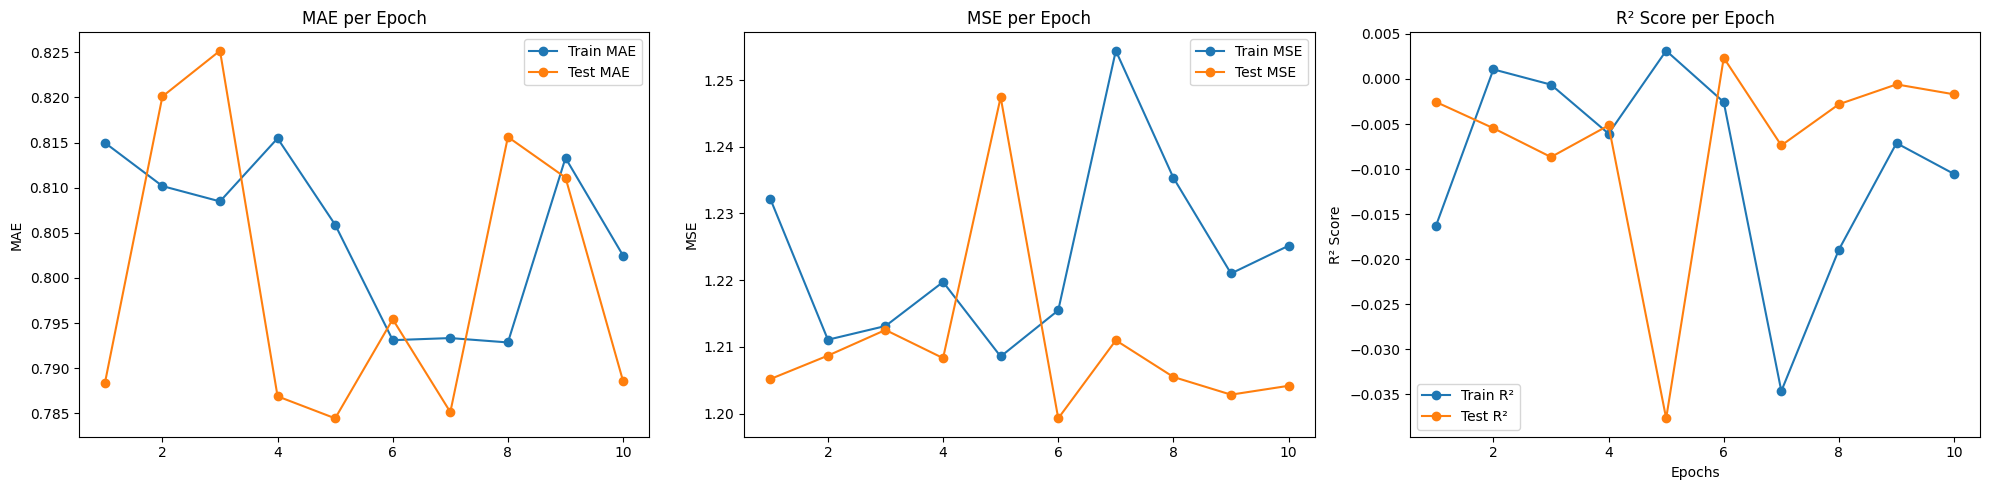

In [27]:
metrics_df = pd.DataFrame(metrics)
metrics_df['epochs'] = np.arange(1,N_EPOCH + 1)

fig, axs = plt.subplots(1, 3, figsize=(20, 5), sharex=True)

axs[0].plot(metrics_df['epochs'], metrics_df['train_mae'], marker='o', label='Train MAE')
axs[0].plot(metrics_df['epochs'], metrics_df['test_mae'], marker='o', label='Test MAE')
axs[2].set_xlabel('Epochs')
axs[0].set_ylabel('MAE')
axs[0].legend()
axs[0].set_title('MAE per Epoch')

axs[1].plot(metrics_df['epochs'], metrics_df['train_mse'], marker='o', label='Train MSE')
axs[1].plot(metrics_df['epochs'], metrics_df['test_mse'], marker='o', label='Test MSE')
axs[2].set_xlabel('Epochs')
axs[1].set_ylabel('MSE')
axs[1].legend()
axs[1].set_title('MSE per Epoch')

axs[2].plot(metrics_df['epochs'], metrics_df['train_r2'], marker='o', label='Train R²')
axs[2].plot(metrics_df['epochs'], metrics_df['test_r2'], marker='o', label='Test R²')
axs[2].set_xlabel('Epochs')
axs[2].set_ylabel('R² Score')
axs[2].legend()
axs[2].set_title('R² Score per Epoch')

plt.tight_layout()
plt.show()

Key observation :
+ MAE :
    + Both Train and Test MAE fluctuate around 0.8 without a clear downward trend.
    + Many epochs show spikes in MAE, indicating instability or poor generalization.

+ MSE : 
    + Shows similar behavior — unstable test MSE, sometimes increasing.
    + This suggests the model may be underfitting or not learning meaningful patterns.

+ R2 :
    + R² scores hover around 0 or below, which means the model fails to explain variance better than a simple mean predictor.
    + Negative R² is a strong indicator of poor model performance.

#### Make Prediction

Predict and calculate metrics on test set

In [28]:
linear_model.eval()
y_true_log, y_pred_log = make_prediction_loader(linear_model, test_loader, DEVICE)
y_true = np.expm1(y_true_log)
y_pred = np.expm1(y_pred_log)
len(y_pred)

240000

In [29]:
mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)
rmsle = root_mean_squared_log_error(y_true, y_pred)

models_performance['mae'].append(mae)
models_performance['mse'].append(mse)
models_performance['r2'].append(r2)
models_performance['rmsle'].append(rmsle)
models_performance['train_time'].append(training_time)
models_performance['model'].append('Linear Model')

### Neural Network With Activation

The second model architecture is a more popular architecture, it consists of :
+ Input layer with input dim equal to the number of the input features.
+ Fully connected layers, with GELU activation function (smoother activation).
+ Batch normalization and drop out technique.
+ Output layer consists of 1 single neuron, designed for regression problem.

In [30]:
class RegressionModel(nn.Module):
    def __init__(self, input_size, hidden_size, n_layers):
        super().__init__()
        layers = [nn.Linear(input_size, hidden_size), nn.BatchNorm1d(hidden_size), nn.GELU()]
    
        for i in range(n_layers):
          layers.append(nn.Linear(in_features=hidden_size, out_features=hidden_size))
          layers.append(nn.BatchNorm1d(hidden_size))
          layers.append(nn.GELU())
          if i % 3 == 0:
            layers.append(nn.Dropout(0.15))
    
    
        layers.append(nn.Linear(in_features=hidden_size, out_features=1))
    
        self.fc_layer = nn.Sequential(*layers)

    def forward(self, X):
        return self.fc_layer(X)


#### Hyperparameters Tunning

Hyperparameters tunning for the RegressionModel, including:
+ `lr` : Learning rate, float value from 0.00001 to 0.01
+ `hidden_size` : Number of neurons in each layer of the model, value range from 16, 32, 64 to 128
+ `n_layers` : Number of hidden layers, the more layer the deeper model but more risk of overfitting, vanishing gradients, slower training.
+ `weight_decay` : L2 regularization strength; discourages large weights. Float value from 0.000001 to 0.01
+ `optimizer` : Trial between SGD, Adam, AdamW, are popular optimizer in deep learning
+ `loss function` : Between MAE or MSE

There are 15 trials in total, each trial will run through the hypertune dataset for 5 epochs to find the best params dict

In [31]:
# def objective(trial):
#     lr = trial.suggest_float("lr", 1e-5, 1e-2, log=True)
#     hidden_size = trial.suggest_categorical("hidden_size", [16, 32, 64, 128])
#     n_layers = trial.suggest_int("n_layers", 1, 10)
#     weight_decay = trial.suggest_float("weight_decay", 1e-6, 1e-2, log=True)

#     optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "AdamW", "SGD"])
#     loss_name = trial.suggest_categorical("loss_function", ['MSE', 'MAE'])

#     model = RegressionModel(input_size=INPUT_SIZE, hidden_size=hidden_size, n_layers=n_layers).to(DEVICE)

#     if loss_name == 'MSE':
#         loss_fn = nn.MSELoss()
#     else:
#         loss_fn = nn.L1Loss()

#     if optimizer_name == "Adam":
#         optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
#     elif optimizer_name == 'AdamW':
#         optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
#     else:
#         optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=weight_decay)

#     scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)

#     metrics = train_model(
#         model=model,
#         train_loader=tune_loader,
#         test_loader=val_optuna,
#         loss_fn=loss_fn,
#         optimizer=optimizer,
#         device=DEVICE,
#         scheduler=scheduler,
#         epochs=5,
#         val_loader=None,
#         log_period=None
#     )

#     final_mae = metrics['test_mae'][-1]
#     return final_mae


# study = optuna.create_study(direction="minimize")
# study.optimize(objective, n_trials=15)

# print("Best trial:")
# trial = study.best_trial
# print(f"  Value (MAE): {trial.value}")
# print("  Params: ")
# for key, value in trial.params.items():
#     print(f"    {key}: {value}")

Best parameters, activation and loss function after optuna

In [32]:
best_params = {'lr': 0.0010912138727819272,
 'hidden_size': 16,
 'n_layers': 9,
 'weight_decay': 0.0006363355086413182,
 'optimizer': 'AdamW',
 'loss_function': 'MAE'}

#### Model Summary

Call a model instance and setup loss function, optimizer

In [33]:
regression_model = RegressionModel(input_size = INPUT_SIZE, hidden_size = 16, n_layers = 9).to(DEVICE)
criterion = nn.L1Loss()
optimizer = torch.optim.AdamW(regression_model.parameters(), lr=  0.0010912138727819272, weight_decay=0.0006363355086413182)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)
regression_model


RegressionModel(
  (fc_layer): Sequential(
    (0): Linear(in_features=15, out_features=16, bias=True)
    (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): GELU(approximate='none')
    (3): Linear(in_features=16, out_features=16, bias=True)
    (4): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): GELU(approximate='none')
    (6): Dropout(p=0.15, inplace=False)
    (7): Linear(in_features=16, out_features=16, bias=True)
    (8): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): GELU(approximate='none')
    (10): Linear(in_features=16, out_features=16, bias=True)
    (11): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): GELU(approximate='none')
    (13): Linear(in_features=16, out_features=16, bias=True)
    (14): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (15): GELU(approximate='non

Summary of the second model : Contain 1 input layer, 1 output layer and 9 block of Linear, Activation and Batch normalization

In [34]:
summary(regression_model)

Layer (type:depth-idx)                   Param #
RegressionModel                          --
├─Sequential: 1-1                        --
│    └─Linear: 2-1                       256
│    └─BatchNorm1d: 2-2                  32
│    └─GELU: 2-3                         --
│    └─Linear: 2-4                       272
│    └─BatchNorm1d: 2-5                  32
│    └─GELU: 2-6                         --
│    └─Dropout: 2-7                      --
│    └─Linear: 2-8                       272
│    └─BatchNorm1d: 2-9                  32
│    └─GELU: 2-10                        --
│    └─Linear: 2-11                      272
│    └─BatchNorm1d: 2-12                 32
│    └─GELU: 2-13                        --
│    └─Linear: 2-14                      272
│    └─BatchNorm1d: 2-15                 32
│    └─GELU: 2-16                        --
│    └─Dropout: 2-17                     --
│    └─Linear: 2-18                      272
│    └─BatchNorm1d: 2-19                 32
│    └─GELU: 2-20    

#### Train The Model

In [35]:
start_time = time.time()
metrics = train_model(
        model=regression_model,
        train_loader=train_loader,
        test_loader=test_loader,
        loss_fn=criterion,
        optimizer=optimizer,
        scheduler=scheduler,
        epochs=N_EPOCH,
        device = DEVICE,
        val_loader=val_loader,
        log_period=2000
    )
end_time = time.time()
training_time = end_time - start_time



Epoch 1/10:


Testing: 100%|██████████| 1875/1875 [00:11<00:00, 162.34it/s]


MAE : 0.78376 | MSE : 1.22093 | R2 : -0.01565

Epoch 2/10:


Testing: 100%|██████████| 1875/1875 [00:11<00:00, 158.65it/s]


MAE : 0.78489 | MSE : 1.21274 | R2 : -0.00883

Epoch 3/10:


Testing: 100%|██████████| 1875/1875 [00:11<00:00, 162.87it/s]


MAE : 0.78372 | MSE : 1.21900 | R2 : -0.01404

Epoch 4/10:


Testing: 100%|██████████| 1875/1875 [00:11<00:00, 157.02it/s]


MAE : 0.77495 | MSE : 1.20972 | R2 : -0.00632

Epoch 5/10:


Testing: 100%|██████████| 1875/1875 [00:11<00:00, 162.47it/s]


MAE : 0.78931 | MSE : 1.27433 | R2 : -0.06007

Epoch 6/10:


Testing: 100%|██████████| 1875/1875 [00:11<00:00, 159.77it/s]


MAE : 0.96578 | MSE : 1.51315 | R2 : -0.25873

Epoch 7/10:


Testing: 100%|██████████| 1875/1875 [00:11<00:00, 164.09it/s]


MAE : 0.89787 | MSE : 1.37599 | R2 : -0.14463

Epoch 8/10:


Testing: 100%|██████████| 1875/1875 [00:11<00:00, 163.76it/s]


MAE : 0.76965 | MSE : 1.19799 | R2 : 0.00344

Epoch 9/10:


Testing: 100%|██████████| 1875/1875 [00:11<00:00, 163.78it/s]


MAE : 0.77217 | MSE : 1.21408 | R2 : -0.00995

Epoch 10/10:


Testing: 100%|██████████| 1875/1875 [00:11<00:00, 163.40it/s]

MAE : 0.76664 | MSE : 1.19365 | R2 : 0.00704


#### Model Performance

Evaluate after each epoch

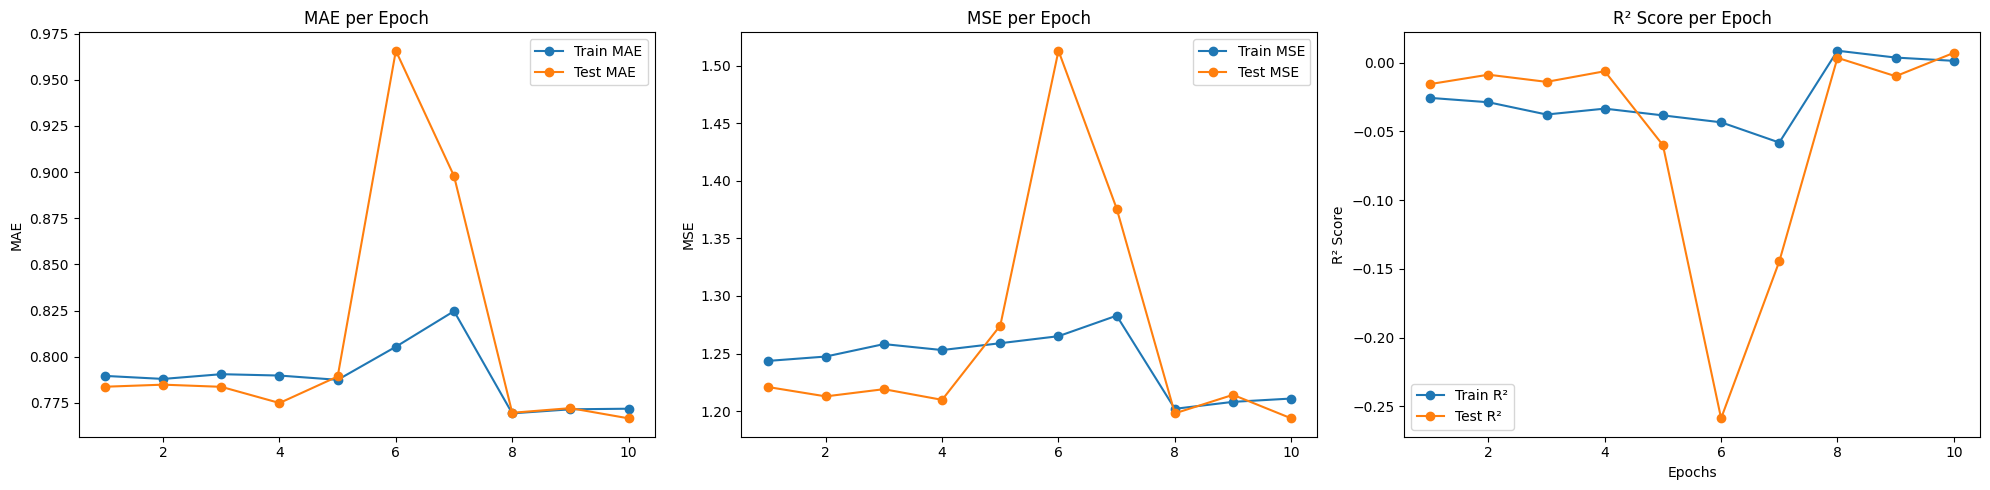

In [36]:
metrics_df = pd.DataFrame(metrics)
metrics_df['epochs'] = np.arange(1,N_EPOCH + 1)

fig, axs = plt.subplots(1, 3, figsize=(20, 5), sharex=True)

axs[0].plot(metrics_df['epochs'], metrics_df['train_mae'], marker='o', label='Train MAE')
axs[0].plot(metrics_df['epochs'], metrics_df['test_mae'], marker='o', label='Test MAE')
axs[2].set_xlabel('Epochs')
axs[0].set_ylabel('MAE')
axs[0].legend()
axs[0].set_title('MAE per Epoch')

axs[1].plot(metrics_df['epochs'], metrics_df['train_mse'], marker='o', label='Train MSE')
axs[1].plot(metrics_df['epochs'], metrics_df['test_mse'], marker='o', label='Test MSE')
axs[2].set_xlabel('Epochs')
axs[1].set_ylabel('MSE')
axs[1].legend()
axs[1].set_title('MSE per Epoch')

axs[2].plot(metrics_df['epochs'], metrics_df['train_r2'], marker='o', label='Train R²')
axs[2].plot(metrics_df['epochs'], metrics_df['test_r2'], marker='o', label='Test R²')
axs[2].set_xlabel('Epochs')
axs[2].set_ylabel('R² Score')
axs[2].legend()
axs[2].set_title('R² Score per Epoch')

plt.tight_layout()
plt.show()

Key observation :
+ MAE:
    + Much smoother than the previous version, with a clear downtrend on train data
    + Both train and test MAE show a generally low and stable trend
    + There a huge spike at epoch 6,7, but the model quickly recover
+ MSE:
    + Also improved, aside from a jump at epoch 6 (same as in MAE), both curves are stable and quite low.
+ R2:
    + Better than the previous model, but still not highly positive, which means the model could be improved further.

In general, this model perform better as it capture non linear relationship

#### Make Prediction

Predict and calculate metrics on test set

In [37]:
regression_model.eval()
y_true_log, y_pred_log = make_prediction_loader(regression_model, test_loader, DEVICE)
y_true = np.expm1(y_true_log)
y_pred = np.expm1(y_pred_log)
len(y_pred)

240000

In [38]:
mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)
rmsle = root_mean_squared_log_error(y_true, y_pred)

models_performance['mae'].append(mae)
models_performance['mse'].append(mse)
models_performance['r2'].append(r2)
models_performance['rmsle'].append(rmsle)
models_performance['train_time'].append(training_time)
models_performance['model'].append('Regression Model')

### Neural Network With Skip Connection

Inspired by ResNet architecture, using skip connection technique. The model architecture consists of:
+ Input layer with the input dim equal to number of input features
+ Multiple hidden layer made of Residual block, each block consists of ReLu activation function, skip connection and batch normalization technique.
+ Ouptut layer with 1 neuron for regression problem

Benefit of this architecture:
+ Improve gradient flow and help train deeper networks.
+ Helps reduce the vanishing gradient problem in deep networks.
+ Allows the model to learn identity mappings when needed (if the block learns nothing, it can just pass the input through)

Reference:
+ https://viblo.asia/p/paper-explain-hieu-ve-skip-connection-mot-ki-thuat-nho-ma-co-vo-trong-cac-kien-truc-residual-networks-3Q75w7bQ5Wb 10/4/2025


In [39]:
class ResidualBlock(nn.Module):
  def __init__(self, hidden_size):
    super().__init__()
    self.fc_layer = nn.Sequential(
        nn.Linear(in_features=hidden_size, out_features=hidden_size),
        nn.BatchNorm1d(hidden_size),
        nn.ReLU(),
    )
  def forward(self, X):
    return X + self.fc_layer(X)

class ResidualNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, n_layers):
      super().__init__()
      layers = [nn.Linear(input_size, hidden_size), nn.BatchNorm1d(hidden_size), nn.ReLU()]
      for i in range(n_layers):
        layers.append(ResidualBlock(hidden_size))
      layers.append(nn.Linear(hidden_size, 1))

      self.fc_layer = nn.Sequential(*layers)


    def forward(self, X):
      return self.fc_layer(X)

#### Hyperparameters Tunning

Hyperparameters tunning for ResidualNetwork, including:
+ `lr` : Learning rate, float value from 0.00001 to 0.01
+ `hidden_size` : Number of neurons in each layer of the model, value range from 16, 32, 64 to 128
+ `n_layers` : Number of residual block, the more the deeper model.
+ `weight_decay` : L2 regularization strength; discourages large weights. Float value from 0.000001 to 0.01
+ `optimizer` : Trial between SGD, Adam, AdamW, are popular optimizer in deep learning
+ `loss function` : Between MAE or MSE

There are 15 trials in total, each trial will run through the hypertune dataset for 5 epochs to find the best params dict

In [40]:
# def objective(trial):
#     lr = trial.suggest_float("lr", 1e-5, 1e-2, log=True)
#     hidden_size = trial.suggest_categorical("hidden_size", [16, 32, 64, 128])
#     n_layers = trial.suggest_int("n_layers", 1, 10)
#     weight_decay = trial.suggest_float("weight_decay", 1e-6, 1e-2, log=True)

#     optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "AdamW", "SGD"])
#     loss_name = trial.suggest_categorical("loss_function", ['MSE', 'MAE'])

#     model = ResidualNetwork(input_size=INPUT_SIZE, hidden_size=hidden_size, n_layers=n_layers).to(DEVICE)

#     if loss_name == 'MSE':
#         loss_fn = nn.MSELoss()
#     else:
#         loss_fn = nn.L1Loss()

#     if optimizer_name == "Adam":
#         optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
#     elif optimizer_name == 'AdamW':
#         optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
#     else:
#         optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=weight_decay)

#     scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)

#     metrics = train_model(
#         model=model,
#         train_loader=tune_loader,
#         test_loader=val_optuna,
#         loss_fn=loss_fn,
#         optimizer=optimizer,
#         device=DEVICE,
#         scheduler=scheduler,
#         epochs=5,
#         val_loader=None,
#         log_period=None
#     )

#     final_mae = metrics['test_mae'][-1]
#     return final_mae


# study = optuna.create_study(direction="minimize")
# study.optimize(objective, n_trials=15)

# print("Best trial:")
# trial = study.best_trial
# print(f"  Value (MAE): {trial.value}")
# print("  Params: ")
# for key, value in trial.params.items():
#     print(f"    {key}: {value}")

Best parameters after optuna

In [41]:
best_params = {'lr': 7.565922798900313e-05,
 'hidden_size': 64,
 'n_layers': 7,
 'weight_decay': 3.145502891757865e-05,
 'optimizer': 'Adam',
 'loss_function': 'MAE'}

#### Model Summary

Call a model instance and setup loss function, optimizer

In [42]:
residual_network = ResidualNetwork(input_size = INPUT_SIZE, hidden_size = 64, n_layers = 7).to(DEVICE)
criterion = nn.L1Loss()
optimizer = torch.optim.Adam(residual_network.parameters(), lr= 7.565922798900313e-05, weight_decay=3.145502891757865e-05)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)
residual_network


ResidualNetwork(
  (fc_layer): Sequential(
    (0): Linear(in_features=15, out_features=64, bias=True)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): ResidualBlock(
      (fc_layer): Sequential(
        (0): Linear(in_features=64, out_features=64, bias=True)
        (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
    )
    (4): ResidualBlock(
      (fc_layer): Sequential(
        (0): Linear(in_features=64, out_features=64, bias=True)
        (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
    )
    (5): ResidualBlock(
      (fc_layer): Sequential(
        (0): Linear(in_features=64, out_features=64, bias=True)
        (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
    )
    (6): ResidualBlock(
      (fc_layer): Sequential(
   

Summary of the third model: 1 input layer, 1 output layer and 7 residual block

#### Train The Model

In [43]:
start_time = time.time()
metrics = train_model(
        model=residual_network,
        train_loader=train_loader,
        test_loader=test_loader,
        loss_fn=criterion,
        optimizer=optimizer,
        scheduler=scheduler,
        epochs=N_EPOCH,
        device = DEVICE,
        val_loader=val_loader,
        log_period=2000
    )
end_time = time.time()
training_time = end_time - start_time



Epoch 1/10:


Testing: 100%|██████████| 1875/1875 [00:11<00:00, 165.87it/s]


MAE : 0.78361 | MSE : 1.22904 | R2 : -0.02240

Epoch 2/10:


Testing: 100%|██████████| 1875/1875 [00:11<00:00, 163.80it/s]


MAE : 0.78328 | MSE : 1.21795 | R2 : -0.01317

Epoch 3/10:


Testing: 100%|██████████| 1875/1875 [00:11<00:00, 161.16it/s]


MAE : 0.78479 | MSE : 1.20431 | R2 : -0.00182

Epoch 4/10:


Testing: 100%|██████████| 1875/1875 [00:11<00:00, 165.67it/s]


MAE : 0.78252 | MSE : 1.19925 | R2 : 0.00239

Epoch 5/10:


Testing: 100%|██████████| 1875/1875 [00:11<00:00, 159.12it/s]


MAE : 0.78510 | MSE : 1.20973 | R2 : -0.00633

Epoch 6/10:


Testing: 100%|██████████| 1875/1875 [00:11<00:00, 157.42it/s]


MAE : 0.77464 | MSE : 1.20012 | R2 : 0.00166

Epoch 7/10:


Testing: 100%|██████████| 1875/1875 [00:11<00:00, 166.82it/s]


MAE : 0.77736 | MSE : 1.20822 | R2 : -0.00507

Epoch 8/10:


Testing: 100%|██████████| 1875/1875 [00:11<00:00, 158.81it/s]


MAE : 0.76970 | MSE : 1.19351 | R2 : 0.00716

Epoch 9/10:


Testing: 100%|██████████| 1875/1875 [00:11<00:00, 163.29it/s]


MAE : 0.76970 | MSE : 1.19435 | R2 : 0.00646

Epoch 10/10:


Testing: 100%|██████████| 1875/1875 [00:11<00:00, 165.75it/s]

MAE : 0.76972 | MSE : 1.19855 | R2 : 0.00297


#### Model Performance

Evaluate the training process

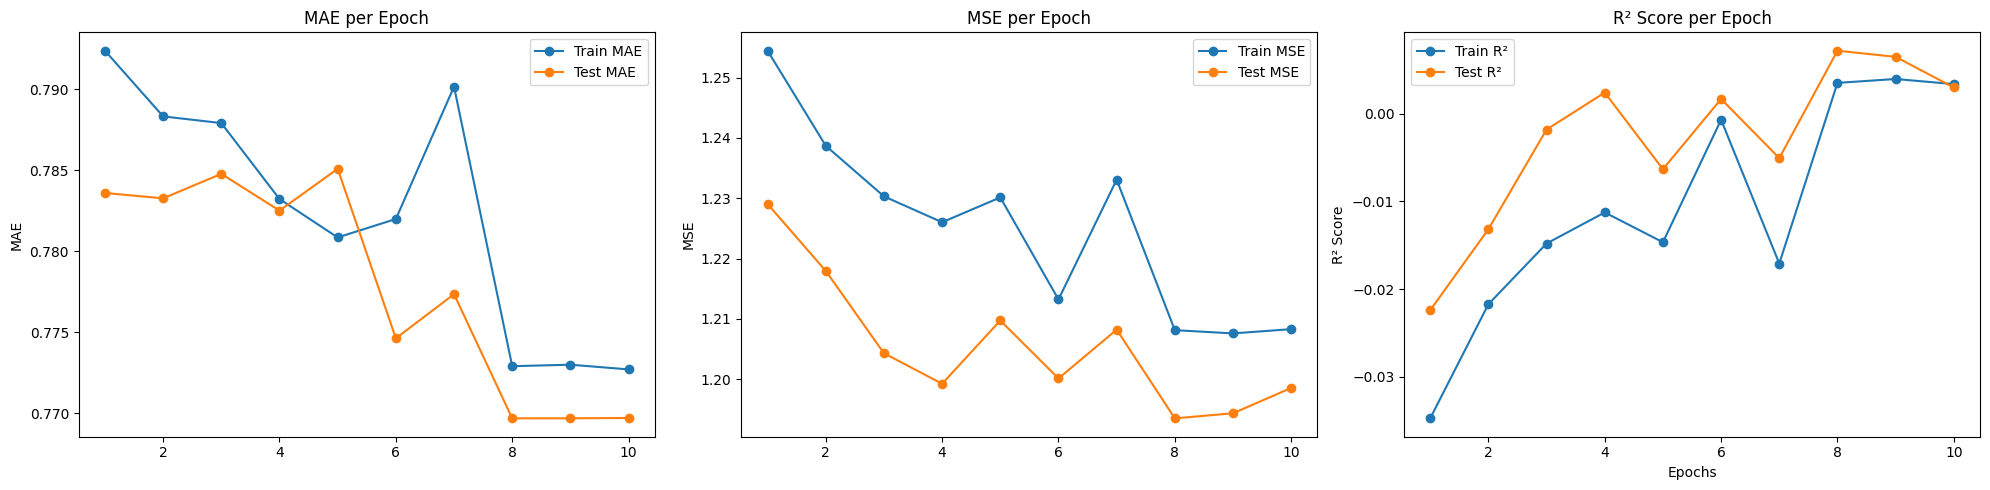

In [44]:
metrics_df = pd.DataFrame(metrics)
metrics_df['epochs'] = np.arange(1,N_EPOCH+1)

fig, axs = plt.subplots(1, 3, figsize=(20, 5), sharex=True)

axs[0].plot(metrics_df['epochs'], metrics_df['train_mae'], marker='o', label='Train MAE')
axs[0].plot(metrics_df['epochs'], metrics_df['test_mae'], marker='o', label='Test MAE')
axs[2].set_xlabel('Epochs')
axs[0].set_ylabel('MAE')
axs[0].legend()
axs[0].set_title('MAE per Epoch')

axs[1].plot(metrics_df['epochs'], metrics_df['train_mse'], marker='o', label='Train MSE')
axs[1].plot(metrics_df['epochs'], metrics_df['test_mse'], marker='o', label='Test MSE')
axs[2].set_xlabel('Epochs')
axs[1].set_ylabel('MSE')
axs[1].legend()
axs[1].set_title('MSE per Epoch')

axs[2].plot(metrics_df['epochs'], metrics_df['train_r2'], marker='o', label='Train R²')
axs[2].plot(metrics_df['epochs'], metrics_df['test_r2'], marker='o', label='Test R²')
axs[2].set_xlabel('Epochs')
axs[2].set_ylabel('R² Score')
axs[2].legend()
axs[2].set_title('R² Score per Epoch')

plt.tight_layout()
plt.show()

Key observation :
+ MAE:
    + Very smooth on the train data, occasional spikes on the test data, but show a clear down trend of loss.
    + The model is generalizing well without significant overfitting.
    + Spike on test data also reflect train data (increasing and decreasing loss).
+ MSE:
    + Same performace as MAE.
    + Spikes in test MSE (decreasing or increasing error) mirror those in MAE.
+ R2:
    + R2 show a clear up trend on bot train and test data
    + Train and test R2 are improving steadily, crossing above 0 in several epochs.

In general : This ResidualNetwork is the best-performing model so far — smoother, more stable, and generalizes well.

#### Make Prediction

Make prediction and calculate metrics

In [45]:
residual_network.eval()
y_true_log, y_pred_log = make_prediction_loader(residual_network, test_loader, DEVICE)
y_true = np.expm1(y_true_log)
y_pred = np.expm1(y_pred_log)
len(y_pred)

240000

In [46]:
mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)
rmsle = root_mean_squared_log_error(y_true, y_pred)

models_performance['mae'].append(mae)
models_performance['mse'].append(mse)
models_performance['r2'].append(r2)
models_performance['rmsle'].append(rmsle)
models_performance['train_time'].append(training_time)
models_performance['model'].append('Residual Network')

### TabNet Regressor

Attentive Interpretable Tabular Learning. Neural network architecture developed by Google AI, designed specifically for tabular data, module `TabNetRegressor` handle simple and and multi-task regression problems

Reference: 
+ https://dreamquark-ai.github.io/tabnet/generated_docs/README.html# 12/4/2025
+ https://www.kaggle.com/code/carlmcbrideellis/tabnet-a-very-simple-regression-example 12/4/2025


#### Hyperparameters Tunning

Hyperparameters tunning for TabNetRegressor, including:
+ `n_steps` : The number of decision steps in the TabNet model. Each step allows the model to learn different representations of the data. 
+ `gamma` : The gamma parameter for the attention mechanism. It controls how diverse each decision step is. A higher value encourages each step to focus on different features (stronger regularization).
+ `lambda_sparse` : The coefficient for sparse regularization. This controls how strongly the model is encouraged to attend to only the most important features. Smaller values apply less regularization.
+ `weight_decay` : L2 regularization strength; discourages large weights. Float value from 0.000001 to 0.01
+ `optimizer` : Trial between SGD, Adam, AdamW, are popular optimizer in deep learning
+ `lr` : Learning rate, float value from 0.00001 to 0.01

There are 15 trials in total, each trial will run through the hypertune dataset for 5 epochs to find the best params dict

In [47]:
# def objective(trial):
#     n_steps = trial.suggest_int("n_steps", 3, 10)
#     gamma = trial.suggest_float("gamma", 1.0, 2.0)
#     lambda_sparse = trial.suggest_float("lambda_sparse", 1e-6, 1e-3, log=True)
#     optimizer_name = trial.suggest_categorical("optimizer", ["adam", "adamw", "sgd"])
#     lr = trial.suggest_float("lr", 1e-4, 1e-2, log=True)

#     model = TabNetRegressor(
#         n_steps=n_steps,
#         gamma=gamma,
#         lambda_sparse=lambda_sparse,
#         optimizer_fn={"adam": torch.optim.Adam, 
#                       "adamw": torch.optim.AdamW, 
#                       "sgd": torch.optim.SGD}[optimizer_name],
#         optimizer_params=dict(lr=lr),
#         device_name=DEVICE
#     )

#     model.fit(
#         X_train=X_optuna.values, y_train=y_optuna.values.reshape(-1,1),
#         eval_set=[(X_val_optuna.values, y_val_optuna.values.reshape(-1,1))],
#         eval_metric=['mae','mse','rmsle'],
#         max_epochs=5,
#         patience=5,
#         batch_size=128,
#         virtual_batch_size=128,
#         num_workers=0,
#         drop_last=False,
#     )

#     preds = model.predict(X_val.values)
#     mae = mean_absolute_error(y_val, preds)
#     return mae

# study = optuna.create_study(direction="minimize")
# study.optimize(objective, n_trials=15)

# print("Best trial:")
# trial = study.best_trial
# print(f"  Value (MAE): {trial.value}")
# print("  Params: ")
# for key, value in trial.params.items():
#     print(f"    {key}: {value}")

Best parameters after optuna

In [48]:
best_params = {
 'n_steps': 3,
 'gamma': 1.8902737866171124,
 'lambda_sparse': 0.00019309404989365227,
 'optimizer': 'adam',
 'lr': 0.001061408877556731}

#### Model Summary

Call and setup model instance

In [49]:
tabnet_model = TabNetRegressor(
    gamma=1.8902737866171124,
    lambda_sparse=0.00019309404989365227,
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=0.001061408877556731),
    device_name=DEVICE
)
tabnet_model

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


TabNetRegressor(n_d=8, n_a=8, n_steps=3, gamma=1.8902737866171124, cat_idxs=[], cat_dims=[], cat_emb_dim=[], n_independent=2, n_shared=2, epsilon=1e-15, momentum=0.02, lambda_sparse=0.00019309404989365227, seed=0, clip_value=1, verbose=1, optimizer_fn=<class 'torch.optim.adam.Adam'>, optimizer_params={'lr': 0.001061408877556731}, scheduler_fn=None, scheduler_params={}, mask_type='sparsemax', input_dim=None, output_dim=None, device_name='cuda', n_shared_decoder=1, n_indep_decoder=1, grouped_features=[])

Parameters:
+ `gamma` : This controls the feature selection sharpness in the TabNet architecture. A higher `gamma` encourages the model to make more decisive feature selection
+ `lambda_sparse`: This is the sparsity regularization coefficient. It encourages the model to use fewer features by penalizing the use of too many.
+ `optimizer` and `optimizer_params` : This sets the optimizer function and learning rate. Adam is a popular choice in deep learning.
+ `device_name` : current device (cpu or gpu)

#### Train The Model

In [50]:
start_time = time.time()
tabnet_model.fit(
    X_train=X_train.values, y_train=y_train.values.reshape(-1,1),
    eval_set=[(X_val.values, y_val.values.reshape(-1,1))],
    eval_metric=['mae','mse','rmse', 'rmsle'],
    max_epochs=N_EPOCH,
    patience=3,
    batch_size = 256,
    num_workers=4,
    drop_last=False,
)
end_time = time.time()
training_time = end_time - start_time

epoch 0  | loss: 2.18275 | val_0_mae: 0.80347 | val_0_mse: 1.2223  | val_0_rmse: 1.10558 | val_0_rmsle: 0.16708 |  0:01:28s
epoch 1  | loss: 1.20885 | val_0_mae: 0.80871 | val_0_mse: 1.2149  | val_0_rmse: 1.10223 | val_0_rmsle: 0.16621 |  0:02:56s
epoch 2  | loss: 1.20464 | val_0_mae: 0.80055 | val_0_mse: 1.20942 | val_0_rmse: 1.09974 | val_0_rmsle: 0.16619 |  0:04:24s
epoch 3  | loss: 1.19988 | val_0_mae: 0.79416 | val_0_mse: 1.20669 | val_0_rmse: 1.09849 | val_0_rmsle: 0.1662  |  0:05:52s
epoch 4  | loss: 1.19106 | val_0_mae: 0.79366 | val_0_mse: 1.19385 | val_0_rmse: 1.09263 | val_0_rmsle: 0.16503 |  0:07:20s
epoch 5  | loss: 1.18521 | val_0_mae: 0.78566 | val_0_mse: 1.18797 | val_0_rmse: 1.08994 | val_0_rmsle: 0.16477 |  0:08:48s
epoch 6  | loss: 1.18062 | val_0_mae: 0.78681 | val_0_mse: 1.18972 | val_0_rmse: 1.09074 | val_0_rmsle: 0.16497 |  0:10:16s
epoch 7  | loss: 1.17825 | val_0_mae: 0.78449 | val_0_mse: 1.18348 | val_0_rmse: 1.08788 | val_0_rmsle: 0.16444 |  0:11:44s
epoch 8 

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


#### Make Prediction

Make prediction and calculate metrics

In [51]:
y_pred = tabnet_model.predict(X_test.values)
y_pred = np.expm1(y_pred)
y_true = np.expm1(y_test)

mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)
rmsle = root_mean_squared_log_error(y_true, y_pred)



In [52]:
models_performance['mae'].append(mae)
models_performance['mse'].append(mse)
models_performance['r2'].append(r2)
models_performance['rmsle'].append(rmsle)
models_performance['train_time'].append(training_time)
models_performance['model'].append('TabNet')

## Evaluation

In [53]:
performance_df = pd.DataFrame(models_performance)
performance_df

,mae,mse,r2,rmsle,train_time,model
0,645.190063,847928.687500,-0.134678,1.097347,646.807431,Linear Model
1,630.493347,817649.812500,-0.094160,1.092545,799.357147,Regression Model
2,632.231140,814636.812500,-0.090128,1.094783,759.382577,Residual Network
3,640.116527,880998.638758,-0.178932,1.081567,1097.001399,TabNet


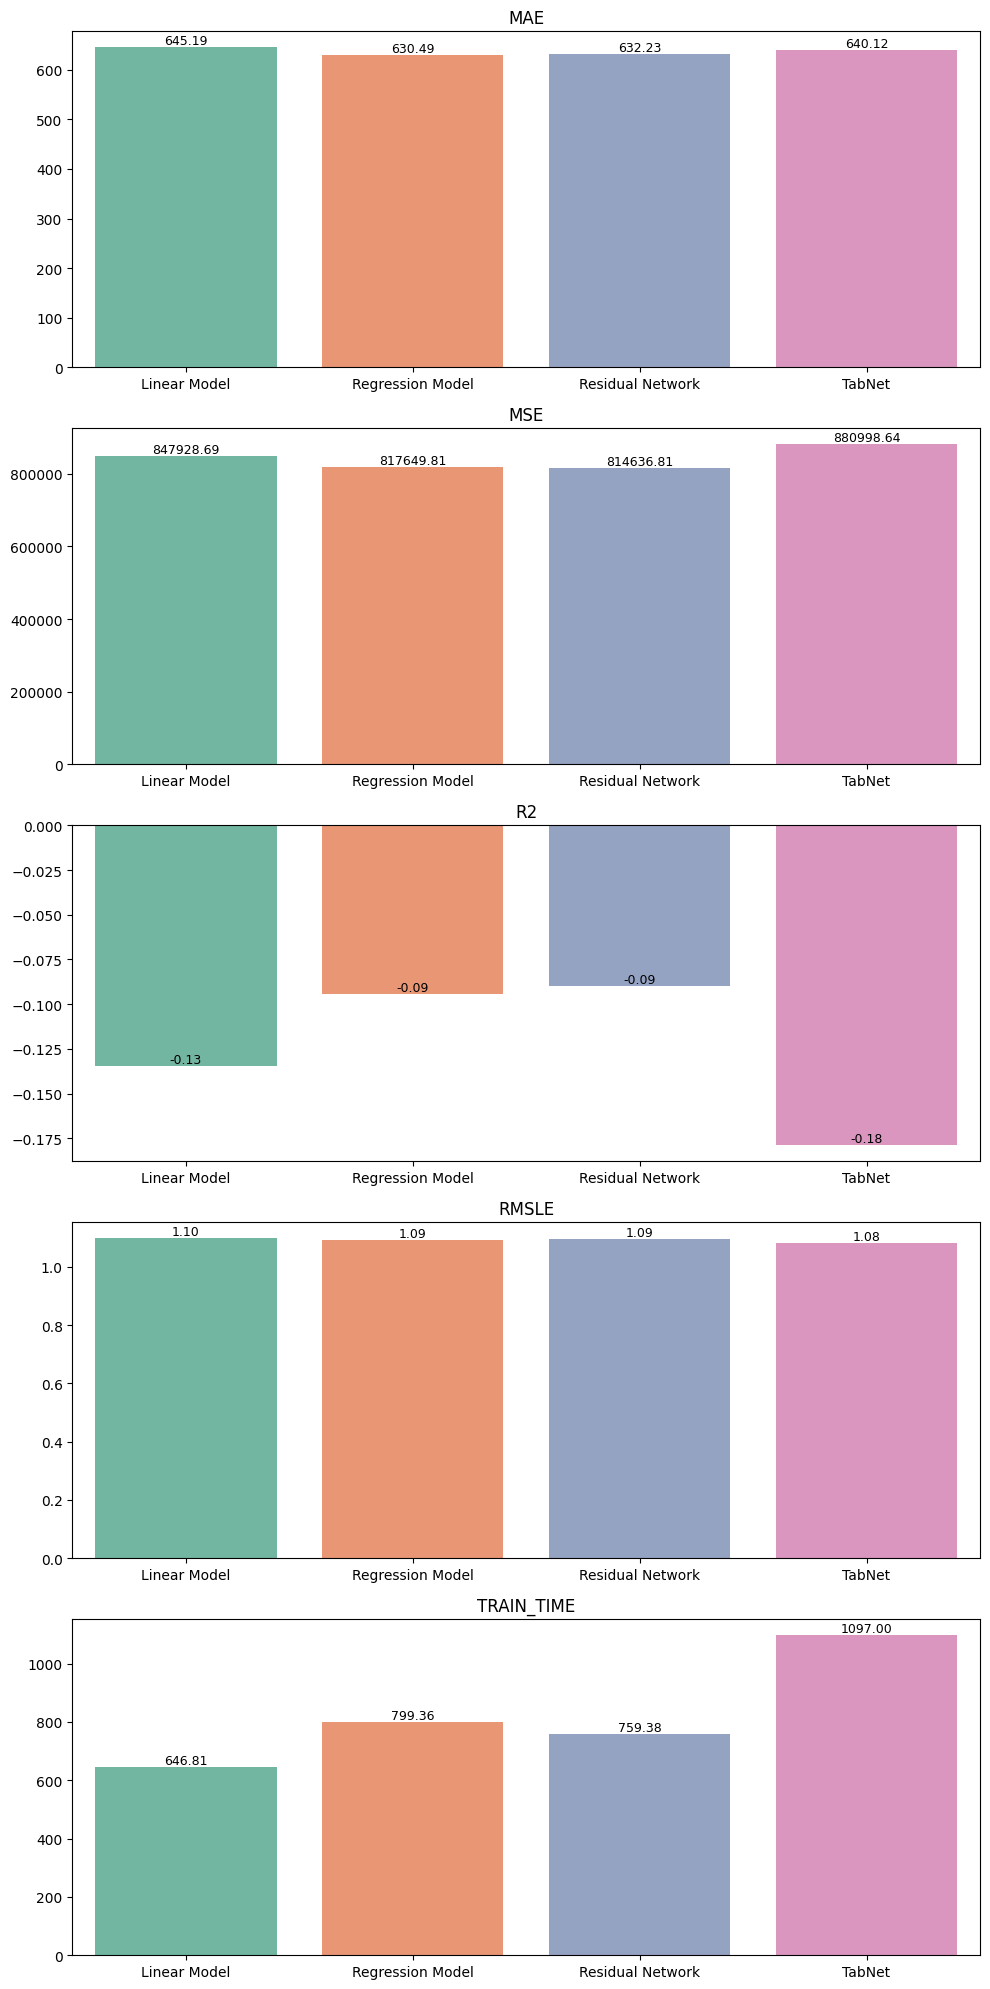

In [54]:
metrics = ['mae', 'mse', 'r2', 'rmsle', 'train_time']
fig, axes = plt.subplots(5, 1, figsize=(10, 20))

for i, metric in enumerate(metrics):
    ax = axes[i]
    sns.barplot(x='model', y=metric, data=performance_df, ax=ax, palette='Set2')
    ax.set_title(metric.upper())
    ax.tick_params(axis='x')
    ax.set_xlabel('')
    ax.set_ylabel('')

    for p in ax.patches:
        value = p.get_height()
        ax.annotate(f'{value:.2f}', 
                    (p.get_x() + p.get_width() / 2., value),
                    ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

Key Observation:
+ MAE :
    + The RegressionModel ResidualNetwork has the lowest MAE in general,  likely due to its deep architecture allowing it to learn more complex relationships in the data.
    + Simple linear model have the highest MAE, too simplistic for the problem

+ MSE:
    + ResidualNetwork also have the lowest MSE, probably captures general trends 
    + TabNetRegressor other models perform decently

+ R2:
    + All models have relative low R2
    + ResidualNetwork learns better variance structure, even if not perfect. Still good overall
    + LinearModel and TabNetRegressor still perform the worst, barely explains any variance, poor fit for complex data.

+ RMSLE :
    + TabNetRegressor have a good RMSLE, indicating the model good at handling skewed distributions and avoiding large proportional errors.
    + Other model perform similarly, neural networks are often solid for this metric, especially with well-scaled data.

+ Training Time:
    + LinearModel train the fastest for it simple and fast forward architect
    + ResidualNetwork and RegressionModel train relatively faster
    + TabNetRegressor train the slowest with heavy computation per epoch

+ Summary:
    + ResidualNetwork give the most consistente and balanced performance
    + TabNetRegressor shows promise, but slow training time make the model take longer to converge
    + LinearModel is not suitable for this problem, due to underfitting and poor variance capture


## Final Model Submission

Since we know the metric is RMSLE, we choose the model with best RMSLE score as our candidate for submission : TabNetRegressor

In [ ]:
y_submit = tabnet_model.predict(np.array(test.values, dtype = np.float32))
y_submit = np.expm1(y_submit)
df_submit = pd.read_csv("/kaggle/input/introml-clc-hk2-2425/test.csv")[['id']].copy()
df_submit['target'] = y_submit

df_submit.to_csv("tabnet_regressor.csv", index = False)


We also choose the best model that balance between all metrics : Residual Network

In [56]:
submit_input = torch.from_numpy(np.array(test.values, dtype = np.float32)).to(DEVICE)

residual_network.eval()
with torch.inference_mode():
    y_submit = residual_network(submit_input).detach().cpu().numpy()
    y_submit = np.expm1(y_submit)
   

In [ ]:
df_submit = pd.read_csv("/kaggle/input/introml-clc-hk2-2425/test.csv")[['id']].copy()
df_submit['target'] = y_submit

df_submit.to_csv("residual_net.csv", index = False)

## Limitation Analysis: Erroneous Cases and Their Properties

1. **Properties of Erroneous Cases**
- **Limited Data Representation**
    - **Observation:**
        - The dataset may lack sufficient representation of certain cases, such as rare categories or extreme target values.
        - Frequency encoding and interaction features were added to address this, but they may not fully capture the underlying patterns.
    - **Impact:**
        - The models may underperform on underrepresented cases, leading to high errors for these instances.
- **Missing Features Label**
    - **Observation:**
        - Columns name or features name in the dataset are missing, therefore we can't judge which feature is important to the target.
    - **Impact:**
        - We were forced to guess the labels and combine the features blindly without involvement of domain knowledge.
- **Skewed Distribution**
    - **Observation:**
        - The distribution of the target variable is imbalance and focus on a specific lower range only 
    - **Impact:**
        -  Some models (like TabNetRegressor) that were initially judged as "not generalizing well" acidentally achieved good RMSLE scores, likely because they tended to predict smaller values overall
- **Too Much Data**
    - **Observation:**
          - The dataset contains an overwhelming number of features and entries, many of which may be irrelevant or redundant.
    - **Impact:**
        - The training process becomes significantly slower and more resource-intensive.
        - It significantly impact the models's architecture, as number of hidden layers, number of neurons and number of epochs has to be reduced in order to manage computational demands, potentially affecting model performance and accuracy.
- **Outliers**
    - **Observation:**
        - The dataset contains significant outliers in the target and other numerical features
    - **Impact:**
        - Unlike boosting and tree algorithm, Neural Network are sensitive to outliers, lead to bias and impact a model's accuracy.

2. **Reasons for Inaccuracy**
- **Model Architecture**
    - **Observation:**
        - Simpler architectures such as LinearModel tend to underfit the data due to their limited capacity to capture complex patterns.
        - More advanced architectures like ResidualNetwork and TabNetRegressor are better suited to the task and demonstrate stronger representational power.
        - However, the number of layers in these models was deliberately restricted to prevent excessive training time and computational cost.
    - **Impact:**
        - As mention above, the limited depth and number of training epochs constrained the models' ability to fully converge and learn fine-grained patterns in the data.
        - As a result, the models may perform sub-optimally, especially on edge cases or instances requiring deeper feature interaction.
- **Overfitting to Noise**
    - **Observation:**
        - The models may overfit to noise in the data, especially for features with low predictive power or high variability.
        - Feature selection was performed to remove low-importance features, but some noise may still remain.
    - **Impact:**
        - Overfitting to noise can reduce the model's ability to generalize, leading to poor performance on the validation set.
- **Metric Sensitivity**
    - **Observation:**
        - RMSLE penalizes large relative errors, making it sensitive to small target values.
        - RMSE penalizes large absolute errors, making it sensitive to extreme target values.
    - **Impact:**
        - The combination of these metrics highlights the models' struggles with both small and extreme target values, reflecting their inability to balance predictions across the entire target range.
